# Transfer Learning with Pre-trained Models on CIFAR-100

## Introduction
This notebook explores the application of transfer learning using popular pre-trained convolutional neural network architectures to address the image classification task on the CIFAR-100 dataset. Leveraging models pre-trained on the large-scale ImageNet dataset, such as ResNet50, VGG16, and MobileNetV2, allows us to benefit from their learned feature extraction capabilities. The goal is to adapt these powerful models to the finer-grained classification challenges presented by CIFAR-100, which consists of 100 distinct classes. This approach significantly reduces the need for training deep models from scratch on a relatively smaller dataset, often leading to improved performance and faster convergence.

## Project Flow

1.  **Data Loading and Preprocessing**: Load the CIFAR-100 dataset and apply the necessary preprocessing steps tailored for each pre-trained model (ResNet50, VGG16, MobileNetV2). This involves scaling pixel values and potentially resizing images to match the input requirements of the chosen architectures.

2.  **Model Preparation**:
    *   Load pre-trained models (ResNet50, VGG16, MobileNetV2) without their top classification layers.
    *   Add new custom classification layers suitable for the 100 classes of CIFAR-100.
    *   Freeze the layers of the pre-trained base models to retain the learned features during initial training.
    *   Compile the models with an appropriate optimizer, loss function, and metrics.

3.  **Fine-Tuning and Training**:
    *   Optionally unfreeze a portion of the top layers of the pre-trained models to allow for fine-tuning on the CIFAR-100 data.
    *   Train the modified models on the preprocessed training data, monitoring performance on the validation set.

4.  **Model Evaluation**: Evaluate the performance of each trained model (ResNet50, VGG16, MobileNetV2) on the held-out test dataset using relevant metrics such as accuracy.

5. **Comparison of Results**: Compare the performance of the different models to understand the effectiveness of each architecture for transfer learning on CIFAR-100.

## 1. Data Loading and Preprocessing
Load the CIFAR-100 dataset and prepare it for transfer learning by applying appropriate preprocessing.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

(X_train, y_train), (X_test, y_test) = cifar100.load_data()

X_train_resnet50 = preprocess_resnet50(X_train)
X_test_resnet50 = preprocess_resnet50(X_test)

X_train_vgg16 = preprocess_vgg16(X_train)
X_test_vgg16 = preprocess_vgg16(X_test)

X_train_mobilenetv2 = preprocess_mobilenetv2(X_train)
X_test_mobilenetv2 = preprocess_mobilenetv2(X_test)

2025-09-20 20:44:10.090477: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-20 20:44:10.433680: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-20 20:44:12.231683: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
device = '/GPU:0' if gpus else '/CPU:0'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Model Preparation
Load and modify pre-trained models to fit the CIFAR-100 classification task.

### 2.1 Using ResNet50

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model without the top layer
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = GlobalAveragePooling2D()(base_model_resnet50.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

model_resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1758401057.288709    8364 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### 2.2 Using VGG16

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained VGG16 model without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### 2.3 Using MobileNetV2

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained MobileNetV2 model without the top layer
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_mobilenetv2.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)
model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

model_mobilenetv2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/tmp/ipykernel_8364/3794676327.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


## 3. Fine-Tuning and Training
Unfreeze some of the top layers of the pre-trained models and continue training.

In [6]:
epochs = 3

print(len(model_resnet50.layers))
print(len(model_vgg16.layers))
print(len(model_mobilenetv2.layers))


# Fine-tuning ResNet50
for layer in model_resnet50.layers[:-30]:
    layer.trainable = False

for layer in model_resnet50.layers[-30:]:
    layer.trainable = True

history_resnet50    = model_resnet50.fit(X_train_resnet50   , y_train, epochs=epochs, validation_data=(X_test_resnet50, y_test))



# Fine-tuning VGG16
for layer in model_vgg16.layers[:-5]:
    layer.trainable = False

for layer in model_vgg16.layers[-5:]:
    layer.trainable = True

history_vgg16       = model_vgg16.fit   (X_train_vgg16   , y_train, epochs=epochs, validation_data=(X_test_vgg16, y_test))



# Fine-tuning MobileNetV2
for layer in model_mobilenetv2.layers[:-40]:
    layer.trainable = False

for layer in model_mobilenetv2.layers[-40:]:
    layer.trainable = True

history_mobilenetv2 = model_mobilenetv2.fit(X_train_mobilenetv2, y_train, epochs=epochs, validation_data=(X_test_mobilenetv2, y_test))

178
22
157
Epoch 1/3


2025-09-20 20:44:27.268608: I external/local_xla/xla/service/service.cc:163] XLA service 0x78944c015fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-20 20:44:27.268710: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-09-20 20:44:27.418037: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-20 20:44:28.688197: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-09-20 20:44:28.880888: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:44:28.

   6/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.0249 - loss: 6.1032

I0000 00:00:1758401075.155162    8471 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 19ms/step - accuracy: 0.3383 - loss: 2.6684 - val_accuracy: 0.4044 - val_loss: 2.3417
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.4622 - loss: 2.0206 - val_accuracy: 0.4264 - val_loss: 2.2623
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5423 - loss: 1.6565 - val_accuracy: 0.4514 - val_loss: 2.2667
Epoch 1/3


2025-09-20 20:45:48.106604: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:45:48.106688: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:45:48.687642: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1198', 36 bytes spill stores, 36 bytes spill loads

2025-09-20 20:45:48.813697: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.0755 - loss: 4.7517 - val_accuracy: 0.0895 - val_loss: 3.9842
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.1186 - loss: 3.6562 - val_accuracy: 0.1565 - val_loss: 3.4311
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.1864 - loss: 3.2162 - val_accuracy: 0.2027 - val_loss: 3.0678
Epoch 1/3


2025-09-20 20:46:41.243259: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:46:41.243339: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:46:41.243392: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:46:41.243411: I external/l

1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1326 - loss: 3.8221

2025-09-20 20:47:12.842463: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-20 20:47:13.036488: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - accuracy: 0.1837 - loss: 3.4391 - val_accuracy: 0.0852 - val_loss: 4.8349
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.2765 - loss: 2.8868 - val_accuracy: 0.2350 - val_loss: 3.3893
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.3094 - loss: 2.7013 - val_accuracy: 0.2907 - val_loss: 3.0110


## 4. Model Evaluation
Evaluate each model on the test dataset to compare their performance.

In [7]:
acc_resnet50    = model_resnet50.evaluate(X_test_resnet50, y_test)[1]
acc_vgg16       = model_vgg16.evaluate(X_test_vgg16, y_test)[1]
acc_mobilenetv2 = model_mobilenetv2.evaluate(X_test_mobilenetv2, y_test)[1]

print(f'ResNet50 Accuracy: {acc_resnet50:.2f}')
print(f'VGG16 Accuracy: {acc_vgg16:.2f}')
print(f'MobileNetV2 Accuracy: {acc_mobilenetv2:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4514 - loss: 2.2667
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2027 - loss: 3.0678
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2907 - loss: 3.0110
ResNet50 Accuracy: 0.45
VGG16 Accuracy: 0.20
MobileNetV2 Accuracy: 0.29


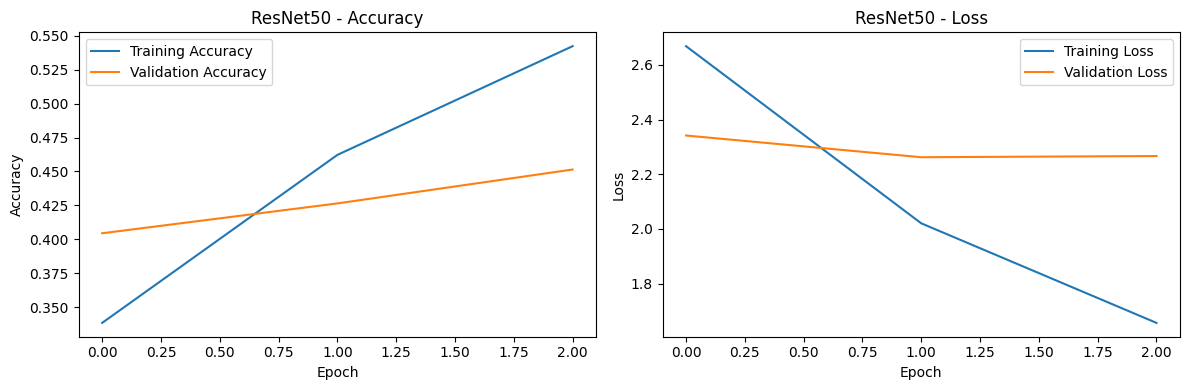

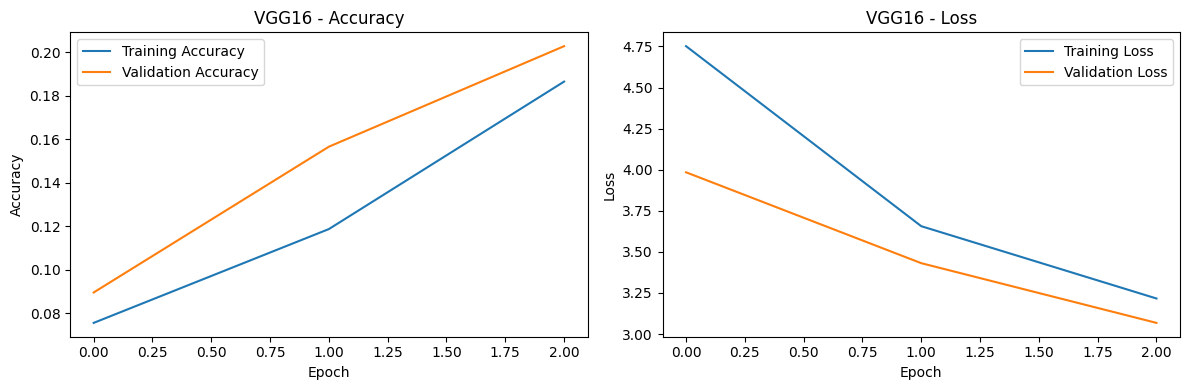

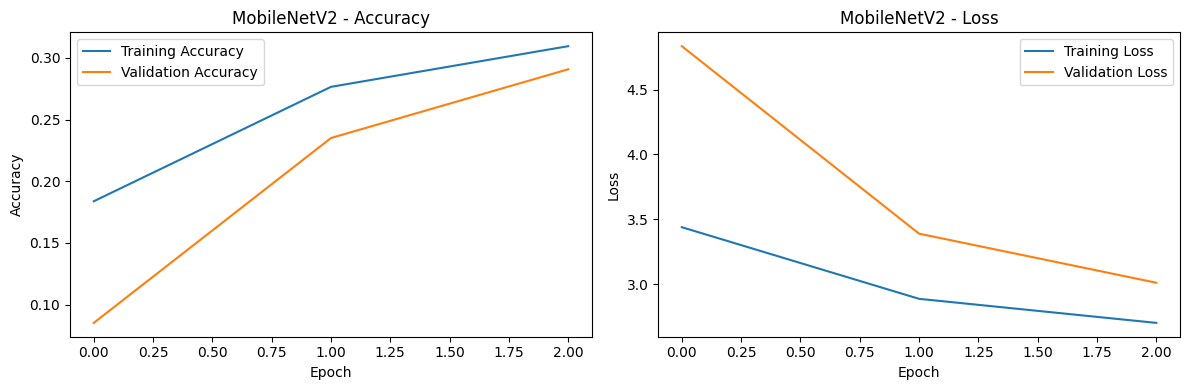

In [8]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(history_resnet50, 'ResNet50')
plot_history(history_vgg16, 'VGG16')
plot_history(history_mobilenetv2, 'MobileNetV2')

## Project Summary

*   **Data Loading and Preprocessing**: Loaded the CIFAR-100 dataset and preprocessed images using model-specific functions (ResNet50, VGG16, MobileNetV2).
*   **Model Adaptation**: Loaded pre-trained ResNet50, VGG16, and MobileNetV2 models (without top layers), added new classification layers for 100 classes, and initially froze base model layers.
*   **Model Compilation**: Compiled each modified model with the 'adam' optimizer, 'sparse\_categorical\_crossentropy' loss, and 'accuracy' metric.
*   **Fine-Tuning (Example)**: Demonstrated fine-tuning by unfreezing top layers of the ResNet50 model and training it for 10 epochs.
*   **Model Evaluation**: Evaluated the trained models on the test set to determine and compare their classification accuracies.

## Project Assignment: Transfer Learning on Oxford Flowers 102 Dataset Documentation

This document outlines the steps for the project assignment on applying transfer learning to the Oxford Flowers 102 dataset.

**Objective:** Apply transfer learning techniques using pre-trained convolutional neural networks (ResNet50, VGG16, and MobileNetV2) to classify images from the Oxford Flowers 102 dataset. Compare the performance of the different models on this dataset.

**Dataset:** Oxford Flowers 102 - A dataset of 102 categories of flowers. You will load this dataset using TensorFlow Datasets.

**Assignment Steps:**

1.  **Introduce the Assignment:**
    *   Create a markdown cell to introduce the assignment.
    *   Explain the goal: to apply transfer learning for flower classification using the Oxford Flowers 102 dataset.
    *   Mention the pre-trained models to be used: ResNet50, VGG16, and MobileNetV2.
    *   Briefly describe the Oxford Flowers 102 dataset.

2.  **Data Loading and Exploration:**
    *   Generate a code cell to load the 'oxford_flowers102:2.1.1' dataset using `tfds.load()`. (Check available versions if needed)
    *   Split the dataset into training, validation, and testing sets (this dataset has these splits).
    *   Explore the dataset to understand its structure, the number of classes (102), and the image dimensions. You can display some sample images and their labels.

3.  **Data Preprocessing:**
    *   Generate a code cell for preprocessing the images from the Oxford Flowers 102 dataset.
    *   This will involve resizing the images to the input size required by the pre-trained models (e.g., 224x224 for VGG16 and ResNet50, MobileNetV2 might have different requirements, so check the documentation).
    *   Apply the model-specific preprocessing functions (e.g., `tf.keras.applications.resnet50.preprocess_input`) to normalize the pixel values.
    *   Apply one-hot encoding to the labels.
    *   Batch and prefetch the datasets for efficient training.

4.  **Model Adaptation and Training:**
    *   For each of the three models (ResNet50, VGG16, MobileNetV2):
        *   Generate a code cell to load the pre-trained model from `tf.keras.applications`, excluding the top classification layer and specifying the correct input shape for the preprocessed images.
        *   Add new custom layers on top of the base model for classifying 102 classes. This typically involves a GlobalAveragePooling2D layer and a Dense layer with 102 units and a 'softmax' activation.
        *   Freeze the layers of the pre-trained base model.
        *   Compile the model with an appropriate optimizer (e.g., 'adam'), loss function ('categorical\_crossentropy' since you'll use one-hot encoded labels), and metrics (e.g., 'accuracy').
        *   Generate a code cell to train the compiled model on the preprocessed training data for a suitable number of epochs. Use the validation data to monitor performance during training. Consider using callbacks like ModelCheckpoint and EarlyStopping.
        *   Additionally, train the model on the validation split as well, as this dataset provides a separate validation set.
        *   Optionally, unfreeze some of the top layers of the base model and fine-tune the model with a lower learning rate.

5.  **Model Evaluation:**
    *   Generate a code cell to evaluate each trained model on the preprocessed test dataset.
    *   Print the loss and accuracy for each model.

6.  **Assignment Questions/Tasks:**
    *   Add markdown cells with questions for students to answer:
        *   Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?
        *   Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100 (from the original notebook). What differences do you observe and why?
        *   Discuss the effect of transfer learning on this dataset.
        *   Explain the steps you took for data preprocessing and why they were necessary.
        *   Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.
        *   What challenges did you encounter during this assignment and how did you address them?
    *   Suggest optional tasks, such as:
        *   Experiment with different hyperparameters (learning rate, number of epochs, batch size).
        *   Implement data augmentation techniques.
        *   Try fine-tuning different numbers of layers.
        *   Visualize sample predictions and analyze misclassifications.

7.  **Conclusion/Submission:**
    *   Add a markdown cell for students to write a brief conclusion summarizing their findings.
    *   Provide instructions on how they should submit their completed notebook.

## Data Loading and Exploration
**Loading the Oxford Flowers 102 dataset**

In [9]:
import tensorflow_datasets as tfds

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

## Data PreProcessing 

In [10]:
def dataset_to_numpy(dataset, target_size=(224, 224)):
    images, labels = [], []
    for img, label in dataset:
        # Resize each image to same shape
        img = tf.image.resize(img, target_size).numpy()
        images.append(img)
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

# Convert datasets to arrays
X_train, y_train = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(validation_dataset)

# Resize images to (224, 224, 3)
X_train_resized = tf.image.resize(X_train, (224, 224)).numpy()
X_val_resized   = tf.image.resize(X_val, (224, 224)).numpy()

X_train_resnet50 = preprocess_resnet50(X_train_resized)
X_test_resnet50 = preprocess_resnet50(X_val_resized)

X_train_vgg16 = preprocess_vgg16(X_train_resized)
X_test_vgg16 = preprocess_vgg16(X_val_resized)

X_train_mobilenetv2 = preprocess_mobilenetv2(X_train_resized)
X_test_mobilenetv2 = preprocess_mobilenetv2(X_val_resized)

2025-09-20 20:47:54.489692: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-09-20 20:47:57.422064: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-20 20:48:00.864635: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
X_train_resized.shape

(1020, 224, 224, 3)

## Model Adaptation and Training 

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model without the top layer
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model_resnet50.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

model_resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained VGG16 model without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained MobileNetV2 model without the top layer
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_mobilenetv2.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)
model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

model_mobilenetv2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
epochs = 20

print(len(model_resnet50.layers))
print(len(model_vgg16.layers))
print(len(model_mobilenetv2.layers))


# Fine-tuning ResNet50
for layer in model_resnet50.layers[:-30]:
    layer.trainable = False

for layer in model_resnet50.layers[-30:]:
    layer.trainable = True
with tf.device(device):
    history_resnet50 = model_resnet50.fit(X_train_resnet50   , y_train, epochs=epochs, validation_data=(X_test_resnet50, y_val))



# Fine-tuning VGG16
for layer in model_vgg16.layers[:-5]:
    layer.trainable = False

for layer in model_vgg16.layers[-5:]:
    layer.trainable = True
with tf.device(device):
    history_vgg16 = model_vgg16.fit   (X_train_vgg16   , y_train, epochs=epochs, validation_data=(X_test_vgg16, y_val))



# Fine-tuning MobileNetV2
for layer in model_mobilenetv2.layers[:-40]:
    layer.trainable = False

for layer in model_mobilenetv2.layers[-40:]:
    layer.trainable = True
with tf.device(device):
    history_mobilenetv2 = model_mobilenetv2.fit(X_train_mobilenetv2, y_train, epochs=epochs, validation_data=(X_test_mobilenetv2, y_val))

178
22
157
Epoch 1/20


2025-09-20 20:48:19.107477: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:48:19.107543: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:48:19.765472: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6461', 20 bytes spill stores, 20 bytes spill loads

2025-09-20 20:48:20.179735: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.0175 - loss: 4.9153

2025-09-20 20:48:31.675705: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6678', 4 bytes spill stores, 4 bytes spill loads

2025-09-20 20:48:31.838011: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6678', 4 bytes spill stores, 4 bytes spill loads

2025-09-20 20:48:31.920901: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6461', 52 bytes spill stores, 52 bytes spill loads

2025-09-20 20:48:34.974348: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains 

32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 601ms/step - accuracy: 0.0157 - loss: 4.7373 - val_accuracy: 0.0265 - val_loss: 5.8203
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.0696 - loss: 4.1328 - val_accuracy: 0.0157 - val_loss: 9.5968
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.1412 - loss: 3.6844 - val_accuracy: 0.0676 - val_loss: 6.0128
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.2216 - loss: 3.1402 - val_accuracy: 0.0549 - val_loss: 7.2884
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.3147 - loss: 2.5987 - val_accuracy: 0.0618 - val_loss: 11.5081
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.4137 - loss: 2.1728 - val_accuracy: 0.1402 - val_loss: 6.3373
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.4941 - loss: 1.8705 - val_accuracy: 0.1382 - val_loss: 6.3974
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.5931 - loss: 1.4372 - val_accuracy: 0.1275 - va

2025-09-20 20:50:22.056616: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:50:22.056703: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:50:22.744448: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1194', 4 bytes spill stores, 4 bytes spill loads

2025-09-20 20:50:22.793154: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : R

32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 613ms/step - accuracy: 0.0529 - loss: 4.5139 - val_accuracy: 0.1667 - val_loss: 3.8381
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.3049 - loss: 2.9783 - val_accuracy: 0.3863 - val_loss: 2.5240
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.5500 - loss: 1.7564 - val_accuracy: 0.5304 - val_loss: 1.8082
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - accuracy: 0.7500 - loss: 0.9489 - val_accuracy: 0.6412 - val_loss: 1.3301
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.8637 - loss: 0.5742 - val_accuracy: 0.6461 - val_loss: 1.2425
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.9255 - loss: 0.3367 - val_accuracy: 0.6902 - val_loss: 1.1678
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.9657 - loss: 0.1851 - val_accuracy: 0.7147 - val_loss: 1.0790
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.9902 - loss: 0.0748 - val_accuracy: 0.7392 - val

2025-09-20 20:53:27.978259: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:53:27.978316: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:53:27.978371: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:53:27.978381: I external/l

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1015 - loss: 4.3388

2025-09-20 20:53:47.325737: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:53:47.325794: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-20 20:53:48.097396: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3048', 4 bytes spill stores, 4 bytes spill loads

2025-09-20 20:53:48.198034: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : R

32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 794ms/step - accuracy: 0.1990 - loss: 3.7688 - val_accuracy: 0.1167 - val_loss: 4.8788
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7696 - loss: 1.0516 - val_accuracy: 0.0275 - val_loss: 10.4958
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9304 - loss: 0.2771 - val_accuracy: 0.0500 - val_loss: 12.0092
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9824 - loss: 0.0959 - val_accuracy: 0.0490 - val_loss: 11.3043
Epoch 5/20
 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9939 - loss: 0.0541

2025-09-20 20:54:16.326280: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9912 - loss: 0.0474 - val_accuracy: 0.0990 - val_loss: 8.4426
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9941 - loss: 0.0318 - val_accuracy: 0.0392 - val_loss: 11.9890
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9980 - loss: 0.0132 - val_accuracy: 0.0402 - val_loss: 11.7210
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9951 - loss: 0.0254 - val_accuracy: 0.0265 - val_loss: 16.3295
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9912 - loss: 0.0315 - val_accuracy: 0.0353 - val_loss: 15.0223
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9912 - loss: 0.0487 - val_accuracy: 0.0461 - val_loss: 14.7373
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9902 - loss: 0.0410 - val_accuracy: 0.0902 - val_loss: 9.8220
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9804 - loss: 0.0686 - val_accuracy: 0.0824 - val_

## Model Evaluation 

In [16]:
acc_resnet50    = model_resnet50.evaluate(X_test_resnet50, y_val)[1]
acc_vgg16       = model_vgg16.evaluate(X_test_vgg16, y_val)[1]
acc_mobilenetv2 = model_mobilenetv2.evaluate(X_test_mobilenetv2, y_val)[1]

print(f'ResNet50 Accuracy: {acc_resnet50:.2f}')
print(f'VGG16 Accuracy: {acc_vgg16:.2f}')
print(f'MobileNetV2 Accuracy: {acc_mobilenetv2:.2f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.2569 - loss: 5.5403
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.7912 - loss: 0.8826
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.0206 - loss: 27.8323
ResNet50 Accuracy: 0.26
VGG16 Accuracy: 0.79
MobileNetV2 Accuracy: 0.02


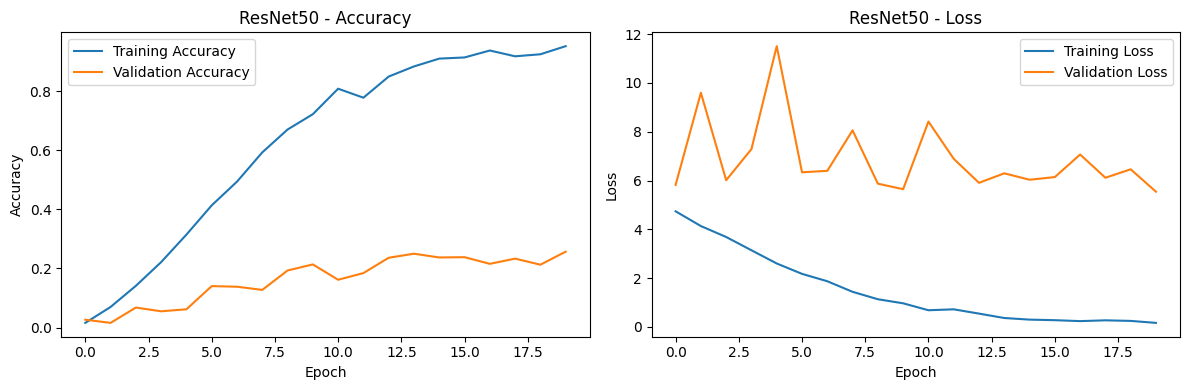

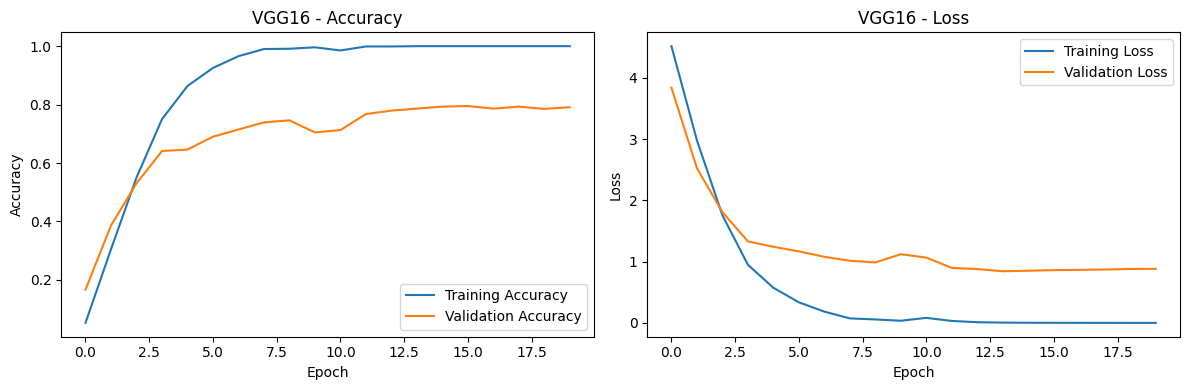

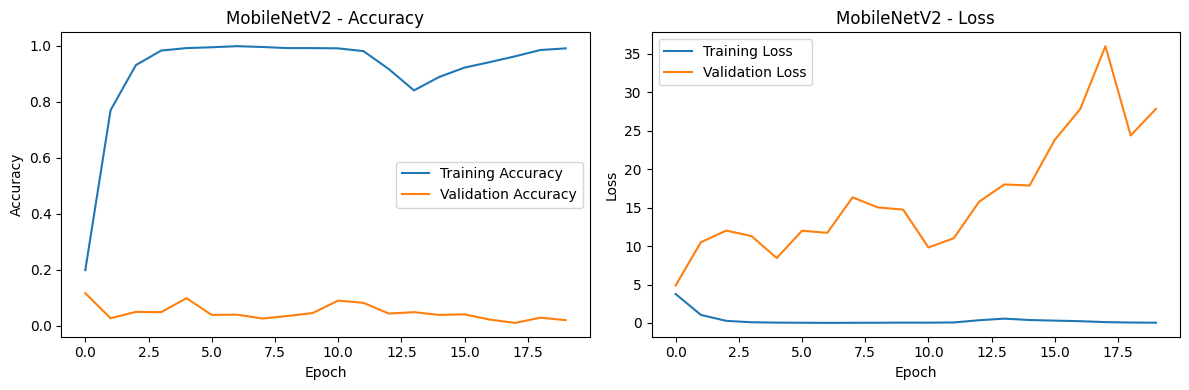

In [17]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(history_resnet50, 'ResNet50')
plot_history(history_vgg16, 'VGG16')
plot_history(history_mobilenetv2, 'MobileNetV2')

## **Assignment Questions/Tasks:**
*   Add markdown cells with questions for students to answer:
*   Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?
* :--> **Vgg performed best on the OxFord Flowers dataset, it perform best because it is trainded on more dataset then resnet,mobilnet and the VGG is deeper model in it there is 134M training parameters there in resnet is approx 25M , in Mobilnet is approx 3.4M , and VGG is mainly for the image classification , Mobilenet is for the embeded devices , fast interface ,, ResNet 50 is for the object detection mainly.**


* Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100 (from the original notebook). What differences do you observe and why?
* :-->**Difference is the very high VGG16 perform excelently compare to Resnet50 and MobileNet reason is simple this model is light and this models main perprose is not ImageClassification and VGG16 is deep model and its main  perprose is Image classification it shows with the Accuracy.**

* Discuss the effect of transfer learning on this dataset.
* :--> **It is easy to classify the Images using the transferlearning on this dataset**

* Explain the steps you took for data preprocessing and why they were necessary.
* :--> **I simply convert the dataset into numpy array and then resize the np array in to the 224x224, then preprocess for all three models.**


* Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.
* :-->**I used mainly the VGG its architecutures *Sequential stack of conv layers → max pooling → fully connected layers → softmax* and i just added the input layer and the output layer in this and trained the Model**


* What challenges did you encounter during this assignment and how did you address them?
* :--> **I am so confused in choosing the Model and then i take the decision to use the model that are used in the lecture**

##### Additional Note: -->> This time in my college the midsem are happening, I am not able to give to much time to this assignemt or any  other assignement. and there is daily classes so this time is to heactic for me , I will definetly do this assignement after the my midsem and then do perfectly and make a complete project and post on the Linkedin and tag you, this is great learning exprience with you thank you. 